In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.math import argmax
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import os
from gym import spaces

In [2]:
rng = np.random.default_rng(358)

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
disc_actions_num = 4

In [5]:
# https://www.gymlibrary.ml/environments/box2d/lunar_lander/

In [6]:
# Using OU Noise
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()
    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x
    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

def get_actor(num_states, num_actions=1, upper_bound=1, continuous=True, layer1=400, layer2=300, 
              init_weights_min=-0.003, init_weights_max=0.003):
    last_init = tf.random_uniform_initializer(minval=init_weights_min, maxval=init_weights_max)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(layer1, activation="relu")(inputs)
    out = layers.LayerNormalization(axis=1)(out)
    out = layers.Dense(layer2, activation="relu")(out)
    out = layers.LayerNormalization(axis=1)(out)
    
    # Different output activation based on discrete or continous version
    if continuous:
        outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)
    else:
        outputs = layers.Dense(disc_actions_num, activation="softmax", kernel_initializer=last_init)(out)

    # Multiply to fill the whole action space which should be equal around 0
    outputs = outputs * upper_bound
    return tf.keras.Model(inputs, outputs)

def get_critic(num_states, num_actions=1, continuous=True, layer1=400, layer2=300):
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(64, activation="relu")(state_input)

    if continuous:
        action_input = layers.Input(shape=(num_actions,))
    else:
        action_input = layers.Input(shape=(disc_actions_num,))
    action_out = layers.Dense(64, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(layer1, activation="relu")(concat)
    out = layers.LayerNormalization(axis=1)(out)
    out = layers.Dense(layer2, activation="relu")(out)
    out = layers.LayerNormalization(axis=1)(out)
    outputs = layers.Dense(num_actions)(out)

    return tf.keras.Model([state_input, action_input], outputs)

# This updates the weights in a slow manner which keeps stability
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [7]:
class Agent:
    def __init__(self, num_states, num_actions=1, lower_bound=-1, upper_bound=1, continuous=True,
            buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002,
            actor_lr=0.001, gamma=0.99, tau=0.005, epsilon=0.2, adam_critic_eps=1e-07,
            adam_actor_eps=1e-07, actor_amsgrad=False, critic_amsgrad=False, actor_layer_1=256, 
            actor_layer_2=256, critic_layer_1=256, critic_layer_2=256):
        
        self.continuous = continuous
        
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        
        # For methods
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

        # This is used to make sure we only sample from used buffer space
        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        if self.continuous:
            self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        else:
            self.action_buffer = np.zeros((self.buffer_capacity, disc_actions_num))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
        # Also keep track if it is in terminal state (legs on ground)
        self.done_buffer = np.zeros((self.buffer_capacity, 1)).astype(np.float32)
        
        self.std_dev = std_dev
        self.critic_lr = critic_lr
        self.actor_lr = actor_lr
        self.gamma = gamma
        self.tau = tau
        
        # Epsilon in epsilon-greedy
        self.epsilon = epsilon
        
        self.actor_model = get_actor(
            num_states, num_actions, upper_bound, continuous=continuous, layer1=actor_layer_1, layer2=actor_layer_2
        )
        self.critic_model = get_critic(
            num_states, num_actions, continuous=continuous, layer1=critic_layer_1, layer2=critic_layer_2
        )
        
        self.target_actor = get_actor(
            num_states, num_actions, upper_bound, continuous=continuous, layer1=actor_layer_1, layer2=actor_layer_2
        )
        self.target_critic = get_critic(
            num_states, num_actions, continuous=continuous, layer1=critic_layer_1, layer2=critic_layer_2
        )
        
        self.actor_optimizer = tf.keras.optimizers.Adam(
            learning_rate=actor_lr, beta_1=0.9, beta_2=0.999, epsilon=adam_actor_eps, amsgrad=actor_amsgrad,
        )
        self.critic_optimizer = tf.keras.optimizers.Adam(
            learning_rate=critic_lr, beta_1=0.9, beta_2=0.999, epsilon=adam_critic_eps, amsgrad=critic_amsgrad,
        )
        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())
        
        self.ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
    
    # Makes a record of the outputted (s,a,r,s') obervation tuple + terminal state
    def record(self, obs_tuple):
        # Reuse the same buffer replacing old entries
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.done_buffer[index] = obs_tuple[4]

        self.buffer_counter += 1
    
    # Calculation of loss and gradients
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            # Add done_batch to y function for terminal state
            y = reward_batch + done_batch * self.gamma * self.target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            l = losses.MeanAbsoluteError()
            critic_loss = l(y, critic_value)

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        
        # Gradient clipping to avoid exploding and vanishing gradients
        critic_gvd = zip(critic_grad, self.critic_model.trainable_variables)
        critic_capped_grad = [(tf.clip_by_value(grad, clip_value_min=-1, clip_value_max=1), var) for grad, var in critic_gvd]
        
        self.critic_optimizer.apply_gradients(critic_capped_grad)

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        # clip actor too
        actor_gvd = zip(actor_grad, self.actor_model.trainable_variables)
        actor_capped_grad = [(tf.clip_by_value(grad, clip_value_min=-1, clip_value_max=1), var) for grad, var in actor_gvd]
        
        self.actor_optimizer.apply_gradients(actor_capped_grad)

    def learn(self):
        # Sample only valid data
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        done_batch = tf.convert_to_tensor(self.done_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch, done_batch)
        
    def policy(self, state, noise_object=0, use_noise=True, noise_mult=1):
        # Default noise_object to 0 for when it is not needed
        # For doing actions without added noise
        if not use_noise:    
            if self.continuous:
                sampled_actions = tf.squeeze(self.actor_model(state)).numpy()
                legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
                return [np.squeeze(legal_action)][0]
            else:
                return self.actor_model(state)
        else:
            if self.continuous:
                sampled_actions = tf.squeeze(self.actor_model(state))
                
                noise = noise_object()
                # Adding noise to action
                sampled_actions = sampled_actions.numpy() + noise * noise_mult

                # We make sure action is within bounds
                legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
                return [np.squeeze(legal_action)][0]
            else:
                if (rng.random() < self.epsilon):
                    #random move
                    action = np.zeros(disc_actions_num)
                    action[np.random.randint(0, disc_actions_num, 1)[0]] = 1
                    return action
                else:
                    return self.actor_model(state)

In [8]:
def fixed(x, episode):
    return x

In [9]:
def run(total_trials=1, total_episodes=100, 
            buffer_capacity=50000, batch_size=64, std_dev=0.3, critic_lr=0.003, render=False,
            actor_lr=0.002, gamma=0.99, tau=0.005, noise_mult=1, save_weights=True, 
            directory='Weights/', actor_name='actor', critic_name='critic',
            gamma_func=fixed, tau_func=fixed, critic_lr_func=fixed, actor_lr_func=fixed,
            noise_mult_func=fixed, std_dev_func=fixed, mean_number=20, output=True,
            return_rewards=False, total_time=True, use_guide=False, solved=200,
            continuous=True, environment='LunarLander-v2', seed=1453, start_steps=0,
            gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5,
            epsilon=0.2, epsilon_func=fixed, adam_critic_eps=1e-07, adam_actor_eps=1e-07,
            actor_amsgrad=False, critic_amsgrad=False, actor_layer_1=256, actor_layer_2=256,
            critic_layer_1=256, critic_layer_2=256):
    tot_time = time.time()
    
    if environment == 'LunarLander-v2':
        env = gym.make(
            "LunarLander-v2",
            continuous=continuous,
            gravity=gravity,
            enable_wind=enable_wind,
            wind_power=wind_power,
            turbulence_power=turbulence_power
        )
    else:
        env = gym.make(environment)
        
    # Apply the seed
    _ = env.reset(seed=seed)
        
    # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    ep_reward_list = []
    # To store average reward history of last few episodes
    avg_reward_list = []
    # To separate assisted reward structures from the "true"
    true_reward_list = []
    true_avg_reward_list = []
    
    for trial in range(total_trials):
        # Stepcount used for random start
        step = 0

        # Add sublists for each trial
        avg_reward_list.append([])
        ep_reward_list.append([])
        true_reward_list.append([])
        true_avg_reward_list.append([])
        
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=buffer_capacity, 
                batch_size=batch_size, std_dev=std_dev, critic_lr=critic_lr, actor_lr=actor_lr, 
                gamma=gamma, tau=tau, epsilon=epsilon, adam_critic_eps=adam_critic_eps, adam_actor_eps=adam_actor_eps,
                actor_amsgrad=actor_amsgrad, critic_amsgrad=critic_amsgrad, actor_layer_1=actor_layer_1, 
                actor_layer_2=actor_layer_2, critic_layer_1=critic_layer_1, critic_layer_2=critic_layer_2)

        for ep in range(total_episodes):
            # functions for different parameters
            agent.gamma = gamma_func(gamma, ep)
            agent.tau = tau_func(tau, ep)
            agent.critic_lr = critic_lr_func(critic_lr, ep)
            agent.actor_lr = actor_lr_func(actor_lr, ep)
            agent.noise_mult = noise_mult_func(noise_mult, ep)
            agent.std_dev = std_dev_func(std_dev, ep)
            agent.epsilon = epsilon_func(epsilon, ep)
            
            # Used for time benchmarking
            before = time.time()

            prev_state = env.reset()
            episodic_reward = 0
            true_reward = 0

            while True:
                if render:
                    env.render()
                
                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

                if step >= start_steps:
                    action = agent.policy(state=tf_prev_state, noise_object=agent.ou_noise, noise_mult=noise_mult)
                else:
                    action = env.action_space.sample()
                
                step += 1
                
                # Recieve state and reward from environment.
                if continuous:
                    state, reward, done, info = env.step(action)
                else:
                    state, reward, done, info = env.step(np.argmax(action))
                
                # Add this before eventual reward modification
                true_reward += reward
                
                # Reward modification
                if use_guide:
                    reward -= abs(state[2]/2) + abs(state[3]) + (abs(state[0])) + (abs(state[1])/2)

                # Add terminal state
                terminal_state = int(not done)
                agent.record((prev_state, action, reward, state, terminal_state))
                episodic_reward += reward

                agent.learn()
                update_target(agent.target_actor.variables, agent.actor_model.variables, agent.tau)
                update_target(agent.target_critic.variables, agent.critic_model.variables, agent.tau)

                if done:
                    break

                prev_state = state

            ep_reward_list[trial].append(episodic_reward)
            true_reward_list[trial].append(true_reward)
            
            avg_reward = np.mean(ep_reward_list[trial][-mean_number:])
            avg_reward_list[trial].append(avg_reward)
            true_avg_reward = np.mean(true_reward_list[trial][-mean_number:])
            true_avg_reward_list[trial].append(true_avg_reward)
            
            if output:
                print("Ep {} * AvgReward {:.2f} * true AvgReward {:.2f} * Reward {:.2f} * True Reward {:.2f} * time {:.2f} * step {}"
                  .format(ep, avg_reward, true_avg_reward, episodic_reward, 
                          true_reward, (time.time() - before), step))
            
            # Stop if avg is above 'solved'
            if true_avg_reward >= solved:
                break

        # Save weights
        now = datetime.datetime.now()
        timestamp = "{}.{}.{}.{}.{}.{}".format(now.year, now.month, now.day, now.hour, now.minute, now.second)
        save_name = "{}_{}_{}".format(
            environment, continuous, 
            timestamp,
        )
        if save_weights:
            try:
                agent.actor_model.save_weights(directory + actor_name + '-trial' + str(trial) + '_' + save_name + '.h5')
            except:
                print('actor save fail')
            try:
                agent.critic_model.save_weights(directory + critic_name + '-trial' + str(trial) + '_' + save_name + '.h5')
            except:
                print('critic save fail')
    
    # Plotting graph
    for idx, p in enumerate(true_avg_reward_list):
        plt.plot(p, label=str(idx))
    plt.xlabel("Episode")
    plt.ylabel("True Avg. Epsiodic Reward (" + str(mean_number) + ")")
    plt.legend()
    try:
        plt.savefig('Graphs/' + save_name + '.png')
    except:
        print('save fig fail')
    plt.show()
    
    print('total time:', time.time() - tot_time, 's')
    
    # Return to be able to make graphs etc. later, or use the data for other stuff
    if return_rewards:
        return true_reward_list

In [10]:
def test(total_episodes=10, actor_weights='Weights/actor-trial0.h5', render=False,
        environment="LunarLander-v2", continuous=True, gravity=-10.0, enable_wind=False,
        wind_power=15.0, turbulence_power=1.5, seed=1453):
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power
    )
    
    # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=0, batch_size=0, 
                std_dev=0, critic_lr=0, actor_lr=0, gamma=0, tau=0, epsilon=0)
        agent.actor_model.load_weights(actor_weights)
        
        while True:
            if render:
                env.render()

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

            action = agent.policy(state=tf_prev_state, use_noise=False)

            if continuous:
                state, reward, done, info = env.step(action)
            else:
                state, reward, done, info = env.step(np.argmax(action))
            
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

In [11]:
def random(total_episodes=10, render=False, environment="LunarLander-v2", continuous=True,
        gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5, seed=1453):
    
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power,
    )
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        before = time.time()
        
        prev_state = env.reset()
        
        while True:
            if render:
                env.render()
            action = env.action_space.sample()
            state, reward, done, _ = env.step(action)
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

---
# Runs and tests
---

Ep 0 * AvgReward -386.01 * true AvgReward -386.01 * Reward -386.01 * True Reward -386.01 * time 2.20 * step 119
Ep 1 * AvgReward -213.52 * true AvgReward -213.52 * Reward -41.02 * True Reward -41.02 * time 0.70 * step 204
Ep 2 * AvgReward -259.11 * true AvgReward -259.11 * Reward -350.28 * True Reward -350.28 * time 0.99 * step 324
Ep 3 * AvgReward -241.78 * true AvgReward -241.78 * Reward -189.82 * True Reward -189.82 * time 1.29 * step 480
Ep 4 * AvgReward -198.69 * true AvgReward -198.69 * Reward -26.33 * True Reward -26.33 * time 0.70 * step 565
Ep 5 * AvgReward -171.30 * true AvgReward -171.30 * Reward -34.36 * True Reward -34.36 * time 1.49 * step 744
Ep 6 * AvgReward -165.62 * true AvgReward -165.62 * Reward -131.53 * True Reward -131.53 * time 1.03 * step 868
Ep 7 * AvgReward -178.63 * true AvgReward -178.63 * Reward -269.71 * True Reward -269.71 * time 0.84 * step 970
Ep 8 * AvgReward -192.93 * true AvgReward -192.93 * Reward -307.26 * True Reward -307.26 * time 0.99 * step 10

Ep 73 * AvgReward -180.94 * true AvgReward -180.94 * Reward -203.97 * True Reward -203.97 * time 1.25 * step 7756
Ep 74 * AvgReward -166.48 * true AvgReward -166.48 * Reward -92.39 * True Reward -92.39 * time 0.57 * step 7825
Ep 75 * AvgReward -169.33 * true AvgReward -169.33 * Reward -112.40 * True Reward -112.40 * time 0.70 * step 7909
Ep 76 * AvgReward -165.35 * true AvgReward -165.35 * Reward -83.52 * True Reward -83.52 * time 0.59 * step 7981
Ep 77 * AvgReward -183.49 * true AvgReward -183.49 * Reward -437.76 * True Reward -437.76 * time 1.51 * step 8162
Ep 78 * AvgReward -185.51 * true AvgReward -185.51 * Reward -101.85 * True Reward -101.85 * time 0.66 * step 8243
Ep 79 * AvgReward -185.00 * true AvgReward -185.00 * Reward -205.70 * True Reward -205.70 * time 0.94 * step 8358
Ep 80 * AvgReward -186.04 * true AvgReward -186.04 * Reward -106.05 * True Reward -106.05 * time 0.83 * step 8460
Ep 81 * AvgReward -193.85 * true AvgReward -193.85 * Reward -177.99 * True Reward -177.99 * 

Ep 145 * AvgReward -199.38 * true AvgReward -199.38 * Reward -72.58 * True Reward -72.58 * time 0.88 * step 15265
Ep 146 * AvgReward -203.82 * true AvgReward -203.82 * Reward -112.59 * True Reward -112.59 * time 0.91 * step 15373
Ep 147 * AvgReward -203.24 * true AvgReward -203.24 * Reward -49.39 * True Reward -49.39 * time 0.65 * step 15451
Ep 148 * AvgReward -199.62 * true AvgReward -199.62 * Reward -111.80 * True Reward -111.80 * time 1.02 * step 15573
Ep 149 * AvgReward -196.52 * true AvgReward -196.52 * Reward -113.90 * True Reward -113.90 * time 1.01 * step 15694
Ep 150 * AvgReward -192.04 * true AvgReward -192.04 * Reward -205.99 * True Reward -205.99 * time 1.03 * step 15818
Ep 151 * AvgReward -187.17 * true AvgReward -187.17 * Reward -61.14 * True Reward -61.14 * time 0.62 * step 15893
Ep 152 * AvgReward -187.26 * true AvgReward -187.26 * Reward -94.51 * True Reward -94.51 * time 0.56 * step 15961
Ep 153 * AvgReward -187.77 * true AvgReward -187.77 * Reward -238.33 * True Rewa

Ep 217 * AvgReward -148.19 * true AvgReward -148.19 * Reward -119.01 * True Reward -119.01 * time 5.04 * step 28202
Ep 218 * AvgReward -139.52 * true AvgReward -139.52 * Reward -162.25 * True Reward -162.25 * time 9.30 * step 28922
Ep 219 * AvgReward -137.49 * true AvgReward -137.49 * Reward -26.83 * True Reward -26.83 * time 13.09 * step 29922
Ep 220 * AvgReward -135.64 * true AvgReward -135.64 * Reward -139.18 * True Reward -139.18 * time 9.85 * step 30694
Ep 221 * AvgReward -132.80 * true AvgReward -132.80 * Reward -207.58 * True Reward -207.58 * time 8.20 * step 31329
Ep 222 * AvgReward -126.90 * true AvgReward -126.90 * Reward -35.85 * True Reward -35.85 * time 1.05 * step 31416
Ep 223 * AvgReward -116.73 * true AvgReward -116.73 * Reward -17.42 * True Reward -17.42 * time 0.85 * step 31487
Ep 224 * AvgReward -110.23 * true AvgReward -110.23 * Reward -51.87 * True Reward -51.87 * time 1.19 * step 31586
Ep 225 * AvgReward -109.39 * true AvgReward -109.39 * Reward -8.28 * True Rewar

Ep 288 * AvgReward -143.28 * true AvgReward -143.28 * Reward -156.17 * True Reward -156.17 * time 0.99 * step 58667
Ep 289 * AvgReward -148.11 * true AvgReward -148.11 * Reward -343.11 * True Reward -343.11 * time 1.26 * step 58773
Ep 290 * AvgReward -165.45 * true AvgReward -165.45 * Reward -450.07 * True Reward -450.07 * time 1.50 * step 58901
Ep 291 * AvgReward -169.39 * true AvgReward -169.39 * Reward -250.30 * True Reward -250.30 * time 8.16 * step 59532
Ep 292 * AvgReward -175.33 * true AvgReward -175.33 * Reward -213.94 * True Reward -213.94 * time 10.25 * step 60327
Ep 293 * AvgReward -179.45 * true AvgReward -179.45 * Reward -163.64 * True Reward -163.64 * time 3.68 * step 60636
Ep 294 * AvgReward -178.86 * true AvgReward -178.86 * Reward -35.37 * True Reward -35.37 * time 5.90 * step 61108
Ep 295 * AvgReward -180.84 * true AvgReward -180.84 * Reward 209.53 * True Reward 209.53 * time 3.36 * step 61386
Ep 296 * AvgReward -178.98 * true AvgReward -178.98 * Reward -139.54 * True

Ep 362 * AvgReward 49.76 * true AvgReward 49.76 * Reward 166.04 * True Reward 166.04 * time 6.18 * step 77860
Ep 363 * AvgReward 58.00 * true AvgReward 58.00 * Reward 21.88 * True Reward 21.88 * time 1.23 * step 77964
Ep 364 * AvgReward 57.48 * true AvgReward 57.48 * Reward -40.55 * True Reward -40.55 * time 1.23 * step 78068
Ep 365 * AvgReward 55.83 * true AvgReward 55.83 * Reward -18.76 * True Reward -18.76 * time 0.84 * step 78139
Ep 366 * AvgReward 57.46 * true AvgReward 57.46 * Reward -20.67 * True Reward -20.67 * time 1.12 * step 78234
Ep 367 * AvgReward 59.63 * true AvgReward 59.63 * Reward 266.57 * True Reward 266.57 * time 2.28 * step 78425
Ep 368 * AvgReward 62.49 * true AvgReward 62.49 * Reward 26.60 * True Reward 26.60 * time 1.44 * step 78547
Ep 369 * AvgReward 68.19 * true AvgReward 68.19 * Reward -50.96 * True Reward -50.96 * time 0.85 * step 78619
Ep 370 * AvgReward 71.20 * true AvgReward 71.20 * Reward 39.15 * True Reward 39.15 * time 0.85 * step 78691
Ep 371 * AvgRewa

Ep 436 * AvgReward 8.29 * true AvgReward 8.29 * Reward -57.23 * True Reward -57.23 * time 0.92 * step 99280
Ep 437 * AvgReward 10.00 * true AvgReward 10.00 * Reward -72.19 * True Reward -72.19 * time 1.09 * step 99372
Ep 438 * AvgReward 19.54 * true AvgReward 19.54 * Reward 20.28 * True Reward 20.28 * time 1.25 * step 99477
Ep 439 * AvgReward 27.40 * true AvgReward 27.40 * Reward 15.82 * True Reward 15.82 * time 4.12 * step 99814
Ep 440 * AvgReward 16.33 * true AvgReward 16.33 * Reward -4.01 * True Reward -4.01 * time 2.39 * step 100010
Ep 441 * AvgReward 14.15 * true AvgReward 14.15 * Reward -133.07 * True Reward -133.07 * time 0.79 * step 100076
Ep 442 * AvgReward 14.74 * true AvgReward 14.74 * Reward -59.64 * True Reward -59.64 * time 0.92 * step 100153
Ep 443 * AvgReward 20.17 * true AvgReward 20.17 * Reward 38.64 * True Reward 38.64 * time 1.21 * step 100254
Ep 444 * AvgReward -2.08 * true AvgReward -2.08 * Reward -157.83 * True Reward -157.83 * time 1.51 * step 100381
Ep 445 * Av

Ep 509 * AvgReward -66.47 * true AvgReward -66.47 * Reward -186.92 * True Reward -186.92 * time 0.90 * step 115302
Ep 510 * AvgReward -72.28 * true AvgReward -72.28 * Reward -192.55 * True Reward -192.55 * time 1.01 * step 115387
Ep 511 * AvgReward -89.06 * true AvgReward -89.06 * Reward -149.58 * True Reward -149.58 * time 0.77 * step 115450
Ep 512 * AvgReward -90.51 * true AvgReward -90.51 * Reward -154.03 * True Reward -154.03 * time 1.07 * step 115539
Ep 513 * AvgReward -95.94 * true AvgReward -95.94 * Reward -211.68 * True Reward -211.68 * time 1.37 * step 115653
Ep 514 * AvgReward -98.36 * true AvgReward -98.36 * Reward -85.89 * True Reward -85.89 * time 0.99 * step 115736
Ep 515 * AvgReward -104.58 * true AvgReward -104.58 * Reward -195.76 * True Reward -195.76 * time 1.20 * step 115836
Ep 516 * AvgReward -107.71 * true AvgReward -107.71 * Reward -239.88 * True Reward -239.88 * time 1.20 * step 115936
Ep 517 * AvgReward -113.56 * true AvgReward -113.56 * Reward -234.26 * True Re

Ep 582 * AvgReward -91.68 * true AvgReward -91.68 * Reward 237.22 * True Reward 237.22 * time 2.24 * step 130559
Ep 583 * AvgReward -69.63 * true AvgReward -69.63 * Reward 256.53 * True Reward 256.53 * time 2.55 * step 130769
Ep 584 * AvgReward -76.84 * true AvgReward -76.84 * Reward -196.23 * True Reward -196.23 * time 10.74 * step 131596
Ep 585 * AvgReward -81.91 * true AvgReward -81.91 * Reward -314.03 * True Reward -314.03 * time 4.80 * step 131984
Ep 586 * AvgReward -91.43 * true AvgReward -91.43 * Reward -246.30 * True Reward -246.30 * time 1.68 * step 132123
Ep 587 * AvgReward -66.94 * true AvgReward -66.94 * Reward 247.29 * True Reward 247.29 * time 3.85 * step 132434
Ep 588 * AvgReward -58.06 * true AvgReward -58.06 * Reward -0.63 * True Reward -0.63 * time 2.33 * step 132626
Ep 589 * AvgReward -37.12 * true AvgReward -37.12 * Reward 253.49 * True Reward 253.49 * time 2.96 * step 132866
Ep 590 * AvgReward -36.89 * true AvgReward -36.89 * Reward -165.08 * True Reward -165.08 * 

Ep 656 * AvgReward 75.13 * true AvgReward 75.13 * Reward -99.42 * True Reward -99.42 * time 1.23 * step 148208
Ep 657 * AvgReward 65.98 * true AvgReward 65.98 * Reward -158.26 * True Reward -158.26 * time 1.65 * step 148346
Ep 658 * AvgReward 49.66 * true AvgReward 49.66 * Reward -43.74 * True Reward -43.74 * time 1.15 * step 148441
Ep 659 * AvgReward 47.32 * true AvgReward 47.32 * Reward -189.62 * True Reward -189.62 * time 1.11 * step 148533
Ep 660 * AvgReward 50.32 * true AvgReward 50.32 * Reward -121.51 * True Reward -121.51 * time 5.55 * step 148985
Ep 661 * AvgReward 24.78 * true AvgReward 24.78 * Reward -235.70 * True Reward -235.70 * time 1.47 * step 149105
Ep 662 * AvgReward 27.54 * true AvgReward 27.54 * Reward -86.55 * True Reward -86.55 * time 12.91 * step 150105
Ep 663 * AvgReward 24.34 * true AvgReward 24.34 * Reward 202.09 * True Reward 202.09 * time 5.91 * step 150574
Ep 664 * AvgReward 28.25 * true AvgReward 28.25 * Reward 267.55 * True Reward 267.55 * time 3.04 * step

Ep 729 * AvgReward 11.19 * true AvgReward 11.19 * Reward 316.59 * True Reward 316.59 * time 4.15 * step 164502
Ep 730 * AvgReward 15.88 * true AvgReward 15.88 * Reward -41.04 * True Reward -41.04 * time 2.21 * step 164681
Ep 731 * AvgReward 56.74 * true AvgReward 56.74 * Reward 208.78 * True Reward 208.78 * time 1.88 * step 164834
Ep 732 * AvgReward 82.48 * true AvgReward 82.48 * Reward -122.80 * True Reward -122.80 * time 0.91 * step 164909
Ep 733 * AvgReward 107.55 * true AvgReward 107.55 * Reward -109.54 * True Reward -109.54 * time 0.82 * step 164977
Ep 734 * AvgReward 122.02 * true AvgReward 122.02 * Reward -75.25 * True Reward -75.25 * time 0.65 * step 165031
Ep 735 * AvgReward 129.01 * true AvgReward 129.01 * Reward -207.36 * True Reward -207.36 * time 1.02 * step 165116
Ep 736 * AvgReward 109.00 * true AvgReward 109.00 * Reward -152.90 * True Reward -152.90 * time 0.81 * step 165184
Ep 737 * AvgReward 87.47 * true AvgReward 87.47 * Reward -148.72 * True Reward -148.72 * time 0.

Ep 802 * AvgReward 57.95 * true AvgReward 57.95 * Reward 9.17 * True Reward 9.17 * time 1.18 * step 178809
Ep 803 * AvgReward 59.69 * true AvgReward 59.69 * Reward 267.97 * True Reward 267.97 * time 2.30 * step 178996
Ep 804 * AvgReward 45.50 * true AvgReward 45.50 * Reward -58.76 * True Reward -58.76 * time 1.75 * step 179141
Ep 805 * AvgReward 44.21 * true AvgReward 44.21 * Reward -168.29 * True Reward -168.29 * time 1.21 * step 179240
Ep 806 * AvgReward 58.23 * true AvgReward 58.23 * Reward 284.84 * True Reward 284.84 * time 2.29 * step 179424
Ep 807 * AvgReward 70.93 * true AvgReward 70.93 * Reward 249.49 * True Reward 249.49 * time 2.35 * step 179616
Ep 808 * AvgReward 82.94 * true AvgReward 82.94 * Reward 284.47 * True Reward 284.47 * time 4.88 * step 180003
Ep 809 * AvgReward 65.60 * true AvgReward 65.60 * Reward -93.23 * True Reward -93.23 * time 2.51 * step 180207
Ep 810 * AvgReward 67.08 * true AvgReward 67.08 * Reward 31.87 * True Reward 31.87 * time 13.78 * step 181207
Ep 8

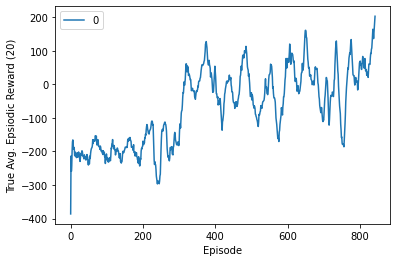

total time: 2305.831007003784 s


In [19]:
run(total_trials=1, total_episodes=1500, buffer_capacity=500000, tau=0.004, critic_lr=0.002, 
    actor_lr=0.001, start_steps=20000, continuous=True)

2.341841697692871s
0.8937985897064209s
0.737602949142456s
1.1789038181304932s
1.5776898860931396s
2.927838087081909s
0.8583450317382812s
2.054826259613037s
0.9302225112915039s
1.343721628189087s


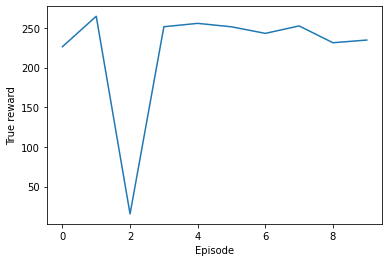

In [24]:
test(render=False, continuous=True, actor_weights='Weights/actor-trial0_LunarLander-v2_True_2022.8.14.21.46.30.h5', seed=1)